# **PROJECT 1 DATA6100**


#Loading data and Missingness chart

**Why this section exists:** before touching models, I want to **see** where the data has gaps.  
I visualize top 20 columns by % missing (bar chart) and also show a small table for quick reference.


[info] train shape: (1000, 82) | test shape: (446, 81)


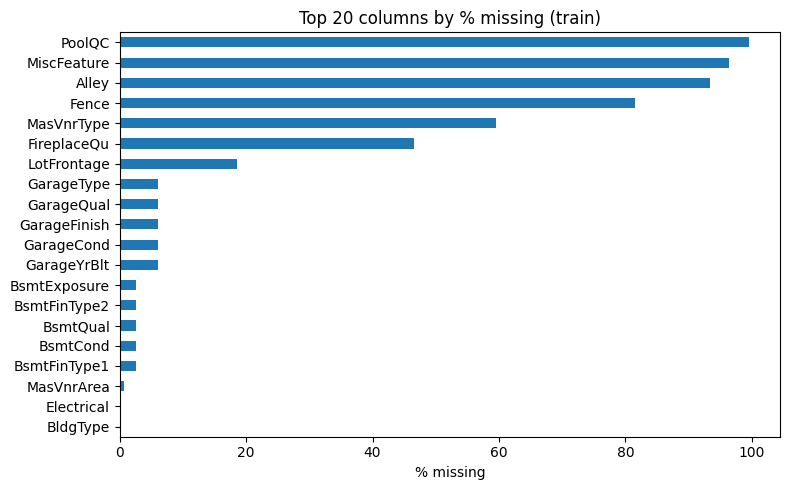

,missing_count,missing_pct
PoolQC,995,99.5
MiscFeature,964,96.4
Alley,934,93.4
Fence,815,81.5
MasVnrType,596,59.6
FireplaceQu,465,46.5
LotFrontage,186,18.6
GarageType,61,6.1
GarageQual,61,6.1
GarageFinish,61,6.1


In [87]:
#Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Load the CSVs
#I have uploaded the datasets on colab manually
#For anyone who wants to run this , make sure you name your files as given below and upload on colab, only then it will work
#Read Train data
train = pd.read_csv("/content/Housing_Data_Train.csv")
#Read Test file
test  = pd.read_csv("/content/Housing_Data_Test.csv")


print(f"[info] train shape: {train.shape} | test shape: {test.shape}")

#Quantify missingness
#I used .isna().sum() to get  counts and .isna().mean()*100 to get percentages.
na_cnt = train.isna().sum().sort_values(ascending=False)
na_pct = (train.isna().mean() * 100).sort_values(ascending=False)

#I combine both into one small table so it's easy to read.
miss = pd.DataFrame({"missing_count": na_cnt, "missing_pct": na_pct})

#isualize the top 20 by % missing
TOPN = 20
plt.figure(figsize=(8,5))
#I reverse the order with .iloc[::-1] so the biggest is on top in the horizontal bar
(miss["missing_pct"].head(TOPN).iloc[::-1]).plot(kind="barh")
plt.title(f"Top {TOPN} columns by % missing (train)")
plt.xlabel("% missing")
plt.tight_layout()
plt.show()

#Show a compact table (rounded %)
display(miss.head(TOPN).round({"missing_pct": 1}))


I can see that PoolQc has 99.5 percent of it's data missing , followed by Alley Fence and so on. Some of the columns here like Alley and PoolQc are missing becuase it is likely that the thing/feature is not present.For example, if a house does not have a pool then how could you judge the quality of the pool.

Therefore in the next step I grouped into categories none and 0, 0 meaning data is not there and none meaning the feature does not exist.

The data is now ready for feature engineering.One good thing that i noticed in this data was that it was regular apart from missingness, I didnot find wierd or absurd entries in the data.


## 2)Feature Engineering


1. **Absence-aware**: if a house *doesn’t have* a basement/garage/pool/etc.  
   → fill **numeric** measures with `0` (e.g., `TotalBsmtSF=0` when no basement) and **categorical** quality with `"None"`.
2. **LotFrontage**: fill by **Neighborhood median** (keeps geography signal).
3. Remaining **numerics**: fill with **median**.  
   Remaining **categoricals**: fill with a literal `"Missing"` token.
4. **Ordinal mapping**: quality strings `Ex/Gd/TA/Fa/Po` → `5/4/3/2/1` (and `0` if truly missing).
5. **Outlier rule** (for LR stability): very large `GrLivArea` but unusually low `SalePrice` (a classic Ames tweak).

Then I make `X` (features) and `y` (target).


In [88]:
#Here I am creating absense aware columns
ABS_NUM = [
    "BsmtUnfSF","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtFullBath","BsmtHalfBath","GarageArea","GarageCars","GarageYrBlt","PoolArea","MasVnrArea"
]

ABS_CAT = [
    "PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType"
]

#Numeric absence = 0
for c in ABS_NUM:
    if c in train.columns: train[c] = train[c].fillna(0)
    if c in test.columns:  test[c]  = test[c].fillna(0)

#Categorical absence = "None"
for c in ABS_CAT:
    if c in train.columns: train[c] = train[c].fillna("None")
    if c in test.columns:  test[c]  = test[c].fillna("None")

#LotFrontage by neighborhood median.Why I do this: frontage strongly depends on neighborhood layout.If a value is missing, I borrow the typical (median) value from that neighborhood.Therefore I get the median from the train data and use it.
if {"LotFrontage","Neighborhood"}.issubset(train.columns):
    nb_med = train.groupby("Neighborhood")["LotFrontage"].median()
    # fill train from its own neighborhood
    train["LotFrontage"] = train["LotFrontage"].fillna(train["Neighborhood"].map(nb_med))
    # fill test using medians learned from TRAIN (safe + consistent)
    if "Neighborhood" in test.columns:
        test["LotFrontage"] = test["LotFrontage"].where(
            ~test["LotFrontage"].isna(),
            test["Neighborhood"].map(nb_med)
        )

#The rest of the missing values
#For anything that is still missing:
#In case of Numbers: I use the median(from train data)
#In case of Categories: I use the "Missing"
import numpy as np
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()

other_num = [c for c in num_cols if c not in ABS_NUM]
other_cat = [c for c in cat_cols if c not in ABS_CAT]

# Numbers → median (fit on TRAIN, apply to TRAIN + TEST)
for c in other_num:
    med = train[c].median()
    train[c] = train[c].fillna(med)
    if c in test.columns: test[c] = test[c].fillna(med)

# Categories → "Missing" token
for c in other_cat:
    train[c] = train[c].fillna("Missing")
    if c in test.columns: test[c]  = test[c].fillna("Missing")

#In some columns I can find things such as Ex Gd Fa used very often , these actually stand for Excellent,Good,Fair,etc .
#These can be given ordered weights so I am turning those into numbers so Linear Regression can use the order.
#Ex=5, Gd=4, TA=3, Fa=2, Po=1, and if truly blank use 0.
qual_map = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}
ord_cols = [
    "ExterQual","ExterCond",
    "BsmtQual","BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual","GarageCond",
    "PoolQC"
]
for c in ord_cols:
    if c in train.columns: train[c] = train[c].map(qual_map).fillna(0)
    if c in test.columns:  test[c]  = test[c].map(qual_map).fillna(0)


#A few points have HUGE living area but surprisingly low price, this is a clear outlier and I am going to drop them I’m dropping them to make the linear regression less sensitive.
removed = 0
if {"GrLivArea","SalePrice"}.issubset(train.columns):
    mask = ~((train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000))
    removed = int((~mask).sum())
    train = train.loc[mask].copy()
print(f"[info] dropped obvious outliers: {removed} | training rows now: {len(train)}")


assert "SalePrice" in train.columns, "SalePrice must exist in the training data."
y = train["SalePrice"].astype(np.float32).copy()
X = train.drop(columns=["SalePrice"]).copy()


[info] dropped obvious outliers: 2 | training rows now: 998



## 3) One‑hot encode and  **80/20 split**

This gives me a clean baseline RMSE (square loss) and R² to confirm the pipeline works before any feature selection or tuning.



In [89]:
#One-hot encode
#I turn all categorical columns into 0/1 dummy columns so Linear Regression can use them.
#I keep ALL dummy columns (drop_first=False) because I prefer simplicity here and later I will use forward selection
X_encoded     = pd.get_dummies(X,    drop_first=False).astype(np.float32)
Xtest_encoded = pd.get_dummies(test, drop_first=False).astype(np.float32)

#I make sure train and test have the exact same columns (same order too).
#If a dummy column exists in train but not in test, I am filling it with 0 in test.
X_encoded, Xtest_encoded = X_encoded.align(Xtest_encoded, join="left", axis=1, fill_value=0)

#Now I will do the 80/20 split
#I do a quick sanity check split: 80% train, 20% validation.
X_tr, X_va, y_tr, y_va = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#I fit a simple Linear Regression on the 80% training part.
lr0 = LinearRegression().fit(X_tr, y_tr)

#I predict on both the training part and the 20% validation part.
pred_tr = lr0.predict(X_tr)
pred_va = lr0.predict(X_va)


#Now I am printing the RMSE
#R² is just an extra “how much variance explained” number for intuition.
mse_tr = mean_squared_error(y_tr, pred_tr)
mse_va = mean_squared_error(y_va, pred_va)
rmse_tr = float(np.sqrt(mse_tr))
rmse_va = float(np.sqrt(mse_va))

print(f"[baseline]  RMSE: {rmse_tr:,.1f} | R²: {r2_score(y_tr, pred_tr):.3f}")
print(f"[baseline]  RMSE: {rmse_va:,.1f} | R²: {r2_score(y_va, pred_va):.3f}")

#I make sure there are no NaNs left afterwards
assert not X_encoded.isna().any().any(), "NaNs remain in X_encoded"
assert not Xtest_encoded.isna().any().any(), "NaNs remain in Xtest_encoded"


[baseline]  RMSE: 25,731.5 | R²: 0.873
[baseline]  RMSE: 27,044.4 | R²: 0.846


Now I will use linear regression

In this section I faced alot of trouble I have tried alot of different ways of using forward section but most of them took more than 2-3 hrs to run so I stopped waiting after 2.30 hr(and in some terrible rmse).
Finally I am using this approach with use 3-fold CV, with a small tolerance + patience stop rule, and cap features. This runs fast.


## 4) **Linear Regression - Forward Selection**

**Goal:** Add features one by one and keep checking if the rmse goes down or not, if it is not significant then stop

I use 3‑fold CV with **RMSE** (set `SCORER='neg_mean_squared_error'`).  





In [90]:
#I build an encoded design matrix once, then I add features one by one only if CV-RMSE gets meaningfully better.
#I keep the knobs simple so it runs fast enough while still improving RMSE.
SEED      = 42
FOLDS     = 3
#I want at least 5% better RMSE to process
TOL_REL   = 0.05
#TOL_ABS   = 200
#after 5 non-improving rounds I stop
PATIENCE  = 5
#It should not run forever but also I don't want it to stop before completion
MAX_FEATS = 50

#Now building  the encoded matrix
#We need preprocess_lr,X,y defined earlier
assert 'preprocess_lr' in globals(), "preprocess_lr not defined above."
assert 'X' in globals() and 'y' in globals(), "X/y must be defined above."

#I drop purely identifier-type columns if they exist
X_processed = X.drop(columns=['Unnamed: 0', 'Id'], errors='ignore')

#Fit the encoder once and turn the data into a table of numbers the model can use
X_encoded_np = preprocess_lr.fit_transform(X_processed)
feature_names = preprocess_lr.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded_np, columns=feature_names).astype(np.float32)
y = y.astype(np.float32)

#Score any set of columns
def cv_rmse_cols(cols):
    #I do KFold CV and return the average RMSE over the folds
    cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    scores = cross_val_score(
        LinearRegression(),
        X_encoded[cols], y,
        scoring="neg_root_mean_squared_error",
        cv=cv, n_jobs=-1, error_score="raise"
    )
    return float(-scores.mean())

#Every encoded column as a candidate
pool_cols = list(X_encoded.columns)

#State I track while selecting
selected   = []
remaining  = pool_cols.copy()
best_rmse  = float("inf")
no_gain    = 0
log        = []

print(f"Forward selection on {len(remaining)} encoded columns "
      f"({FOLDS}-fold CV |  {TOL_REL*100:.1f}% | patience: {PATIENCE} | max_feats: {MAX_FEATS})")

#Adding one new feature each round and keep it only if it helps
while remaining and len(selected) < MAX_FEATS:
    #I look for the one feature that gives me the lowest CV-RMSE when added now
    best_feat, best_this_round = None, float("inf")
    for f in remaining:
        cols = selected + [f]
        rmse_f = cv_rmse_cols(cols)
        if rmse_f < best_this_round:
            best_this_round, best_feat = rmse_f, f

    #Checking if the improvement is big enough to be worth keeping
    gain_abs = best_rmse - best_this_round
    gain_rel = (gain_abs / best_rmse) if np.isfinite(best_rmse) else np.inf
    meaningful = (gain_abs >= TOL_ABS) or (gain_rel >= TOL_REL) or (not np.isfinite(best_rmse))

    #I log the step for my report
    log.append({
        "k": len(selected) + (1 if meaningful else 0),
        "candidate": best_feat,
        "cv_rmse": best_this_round,
        "gain_abs": (None if not np.isfinite(best_rmse) else float(gain_abs)),
        "gain_rel_pct": (None if not np.isfinite(best_rmse) else float(gain_rel*100)),
        "kept": bool(meaningful)
    })

    #If it helped enough,keep it ,otherwise I skip it and count no-gain round
    if meaningful:
        selected.append(best_feat)
        remaining.remove(best_feat)
        best_rmse = best_this_round
        no_gain = 0
        print(f"[k={len(selected):>2}] kept: {best_feat:<40} | CV RMSE → {best_rmse:,.1f}")
    else:
        remaining.remove(best_feat)
        no_gain += 1
        print(f"[skip {no_gain}/{PATIENCE}] best still {best_rmse:,.1f}")
        if no_gain >= PATIENCE:
            print("Early stop(no meaningful improvement for several rounds).")
            break

#I do this so that I can use these results in next cells
#final chosen features
FS_FEATURES      = selected[:]
#best CV-RMSE  achieved here
FS_CV_BEST_RMSE  = best_rmse
path_df = pd.DataFrame(log)

print(f"\n[FS summary] selected {len(FS_FEATURES)} features; "
      f"best CV RMSE ≈ {FS_CV_BEST_RMSE:,.1f} ({FOLDS}-fold)")

#I show a quick peek of the start and end
try:
    from IPython.display import display
    display(pd.concat([path_df.head(6), path_df.tail(6)]))
except Exception:
    print(path_df.head(6))
    print("...")
    print(path_df.tail(6))


Forward selection on 256 encoded columns (3-fold CV |  5.0% | patience: 5 | max_feats: 50)
[k= 1] kept: remainder__OverallQual                   | CV RMSE → 42,821.6
[k= 2] kept: remainder__GrLivArea                     | CV RMSE → 37,089.8
[k= 3] kept: remainder__BsmtFinSF1                    | CV RMSE → 33,093.8
[k= 4] kept: remainder__ExterQual                     | CV RMSE → 31,012.5
[k= 5] kept: remainder__MSSubClass                    | CV RMSE → 29,657.5
[k= 6] kept: cat__BsmtExposure_Gd                     | CV RMSE → 28,385.5
[k= 7] kept: cat__SaleCondition_Partial               | CV RMSE → 27,203.5
[k= 8] kept: remainder__GarageCars                    | CV RMSE → 26,541.5
[k= 9] kept: cat__Neighborhood_NridgHt                | CV RMSE → 25,944.2
[k=10] kept: remainder__KitchenQual                   | CV RMSE → 25,536.5
[k=11] kept: cat__Neighborhood_OldTown                | CV RMSE → 25,222.7
[k=12] kept: remainder__OverallCond                   | CV RMSE → 24,897.1
[k=13] ke

,k,candidate,cv_rmse,gain_abs,gain_rel_pct,kept
0,1,remainder__OverallQual,42821.640625,NaN,NaN,True
1,2,remainder__GrLivArea,37089.787760,5731.852865,13.385412,True
2,3,remainder__BsmtFinSF1,33093.792318,3995.995443,10.773843,True
3,4,remainder__ExterQual,31012.496094,2081.296224,6.289083,True
4,5,remainder__MSSubClass,29657.479167,1355.016927,4.369261,True
5,6,cat__BsmtExposure_Gd,28385.531901,1271.947266,4.288791,True
17,18,cat__Neighborhood_StoneBr,23189.771484,209.509115,0.895366,True
18,18,cat__SaleCondition_Normal,23026.795573,162.975911,0.702792,False
19,18,cat__SaleCondition_Abnorml,23028.733073,161.038411,0.694437,False
20,18,cat__Neighborhood_ClearCr,23061.220052,128.551432,0.554345,False


From this I get 20 best features , I acknowledge that there could have been small improvements by adding in even more features(by reducing the improvement threshold) but it also increases the complexity therefore I feel this is the sweet spot.


Now I have to make sure from the selected features that they are not corelated with each other

In [91]:
# De-correlate after selection
# I start from FS_FEATURES and try to drop very similar (>0.80 corr) columns to keep LR simpler.

assert 'FS_FEATURES' in globals(), "FS_FEATURES must be defined from forward selection."
assert 'X_encoded' in globals() and 'y' in globals(), "X_encoded and y must be defined above."

# I Sync folds with the rest; if not set, I default to 5
try:
    FOLDS
except NameError:
    FOLDS = 3
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# I am scoring the selected set once as my baseline
baseline_scores = cross_val_score(
    LinearRegression(), X_encoded[FS_FEATURES], y,
    scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1
)
baseline_rmse = float(-baseline_scores.mean())
print(f"[prune] baseline CV RMSE: {baseline_rmse:,.1f} using {len(FS_FEATURES)} features")

# Now computing absolute correlations within the selected block
corr = np.abs(X_encoded[FS_FEATURES].corr())
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.80)]
print(f"[prune] high-corr candidates (|r|>0.80): {to_drop if to_drop else '(none)'}")

# Build a pruned list by dropping those columns
pruned = [f for f in FS_FEATURES if f not in to_drop]

# If it is too small, I have to revert
MIN_FEATS = 10
if len(pruned) < MIN_FEATS:
    print(f"[prune] too aggressive (<{MIN_FEATS}); reverting to original.")
    pruned = FS_FEATURES[:]

# Now scoring the pruned set
pruned_scores = cross_val_score(
    LinearRegression(), X_encoded[pruned], y,
    scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1
)
pruned_rmse = float(-pruned_scores.mean())
print(f"[prune] pruned  CV RMSE: {pruned_rmse:,.1f} using {len(pruned)} features")

# I Decide which one to keep for the final model (slight tolerance to prefer simpler)
TOL_KEEP = 50.0
if pruned_rmse <= baseline_rmse + TOL_KEEP:
    FINAL_FEATURES = pruned
    print(f"[prune] I will use the PRUNED set ({len(FINAL_FEATURES)}).")
else:
    FINAL_FEATURES = FS_FEATURES[:]
    print(f"[prune] Pruning didn’t help; I keep the original selected set ({len(FINAL_FEATURES)}).")

[prune] baseline CV RMSE: 23,189.8 using 18 features
[prune] high-corr candidates (|r|>0.80): (none)
[prune] pruned  CV RMSE: 23,189.8 using 18 features
[prune] I will use the PRUNED set (18).


There were no features that were highly correlated to each other.



## 5) Final Linear Regression
- I **don’t re-run the selection** here; I simply fit LR on the chosen `FS_FEATURES`.  
- I report **3-fold CV RMSE** and **3-fold CV MSE** (square loss).  
- I create `/content/submission.csv` with a single `SalePrice` column (floats — **no rounding**).  
- I print the **top positive/negative coefficients** (by magnitude) for interpretability.


In [92]:
#I check that forward selection actually picked something
assert len(FS_FEATURES) > 0, "Forward selection chose no features — rerun cell 4."

#Subset to the features I decided to keep
#I use the same columns for train and hidden test; if a dummy is missing in test,I willfill it with 0
use_cols = [c for c in FS_FEATURES if c in X_encoded.columns]
X_final     = X_encoded[use_cols]
Xtest_final = Xtest_encoded.reindex(columns=use_cols, fill_value=0)

#Fit one plain Linear Regression on ALL training data
lr = LinearRegression().fit(X_final, y)

#Reporting 3-fold CV
rmse_scores = -cross_val_score(lr, X_final, y, scoring="neg_root_mean_squared_error",cv=3, n_jobs=-1)
mse_scores  = -cross_val_score(lr, X_final, y, scoring="neg_mean_squared_error",cv=3, n_jobs=-1)

print(f"[final] Linear Regression with {len(use_cols)} selected features")
print(f"[final] CV RMSE (mean ± sd): {rmse_scores.mean():,.1f} ± {rmse_scores.std(ddof=1):,.1f}")
print(f"[final] CV  MSE (square loss): {mse_scores.mean():,.0f}")

#Predict the hidden test set and write the submission file
test_preds = lr.predict(Xtest_final).astype(float)
pd.DataFrame({'SalePrice': test_preds}).to_csv('/content/submission.csv', index=False)
print('[final] Wrote /content/submission.csv')

#Now I am showing coefficients to discuss which features push prices up/down
coef = pd.Series(lr.coef_, index=use_cols)
print('\\n[top +] Features most positively associated with SalePrice:')
#Displaying top 10 positively associated features
display(coef.sort_values(ascending=False).head(10).to_frame('coef'))
print('[top -] Features most negatively associated with SalePrice:')
display(coef.sort_values(ascending=True).head(4).to_frame('coef'))
#Displaying top 4 negatively associated features


[final] Linear Regression with 18 selected features
[final] CV RMSE (mean ± sd): 23,767.3 ± 609.3
[final] CV  MSE (square loss): 565,132,053
[final] Wrote /content/submission.csv
\n[top +] Features most positively associated with SalePrice:


,coef
cat__Neighborhood_NridgHt,31512.892578
cat__BsmtExposure_Gd,27570.246094
cat__SaleCondition_Partial,26206.648438
cat__Neighborhood_NoRidge,25276.289062
cat__Neighborhood_StoneBr,23506.080078
cat__Exterior1st_BrkFace,22274.863281
remainder__OverallQual,10284.229492
remainder__KitchenQual,7722.460449
remainder__ExterQual,7688.567871
remainder__GarageCars,7258.370117


[top -] Features most negatively associated with SalePrice:


,coef
cat__Neighborhood_OldTown,-11165.418945
remainder__BedroomAbvGr,-6812.490234
remainder__MSSubClass,-170.783340
remainder__TotalBsmtSF,12.354782



## 6) Overfitting vs Underfitting Using KNN

**Why KNN here:** KNN has very good **overfit - sweet spot - underfit** curve
I standardize features and sweep `k` from 1..60.  
KNN was also used to class therefore I am even more inclined to use KNN to show Overfitting vs Underfitting

I used KNN on a small numeric set (OverallQual, GrLivArea, TotalBsmtSF, GarageCars, YearBuilt, FullBath). I standardized them so that distance is fair.In knn k is the single hyperparameter. I scanned k = 1 to k=60 , earlier I was trying with 50 but then I decided to take 60(there are 1000 rows and if I take the root of that I get nearly 31 and double of that is 62,therefore I used 60 to visualise the graph but 50 works well too) . I measured performance with 5-fold CV RMSE (seed=42 for repeatability).


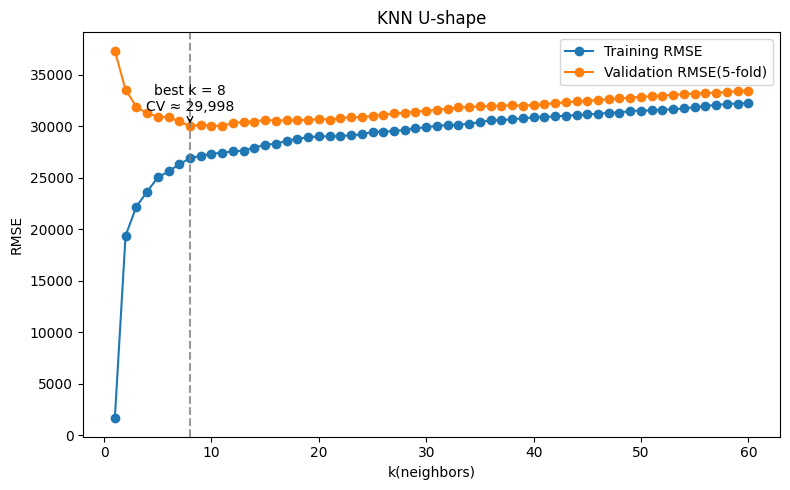

[knn]best k = 8 | best 5-fold CV RMSE ≈ 29,998


In [93]:
#I am Pick a compact numeric set with clear signal(to keep the plot clean and runtime fast)
knn_cols=[c for c in ["OverallQual","GrLivArea","TotalBsmtSF","GarageCars","YearBuilt","FullBath"]
          if c in X.columns]
X_knn=X[knn_cols].astype(np.float32).copy()

#I sweep k from 1 to 60,this is wide enough to see under→best→overfit behavior
ks=list(range(1,61))
train_rmse,cv_rmse=[],[]

#Iuse 5-fold CV with shuffling so the CV line is an honest validation curve
cv5=KFold(n_splits=5,shuffle=True,random_state=42)

for k in ks:
    #IPipeline=standardize features(very important for distance models)→KNN with k neighbors
    pipe=Pipeline([
        ("scaler",StandardScaler()),
        ("knn",KNeighborsRegressor(n_neighbors=k))
    ])

    #Icompute TRAIN error by fitting on all rows(this shows the blue decreasing line)
    pipe.fit(X_knn,y)
    yhat=pipe.predict(X_knn)
    train_rmse.append(float(np.sqrt(((y-yhat)**2).mean())))

    #Icompute VALIDATION error via CV(this is the orange U-curve we care about)
    scores=cross_val_score(pipe,X_knn,y,
                           scoring="neg_root_mean_squared_error",
                           cv=cv5,n_jobs=-1)
    cv_rmse.append(float(-scores.mean()))

#Find the k with the smallest CV RMSE(the bottom of the orange curve)
best_idx=int(np.argmin(cv_rmse))
best_k=ks[best_idx]
best_cv=cv_rmse[best_idx]

#Ploting the U-shape and mark the best k
plt.figure(figsize=(8,5))
plt.plot(ks,train_rmse,marker="o",label="Training RMSE")
plt.plot(ks,cv_rmse,marker="o",label="Validation RMSE(5-fold)")
plt.axvline(best_k,color="gray",ls="--",alpha=0.8)
plt.annotate(f"best k = {best_k}\nCV ≈ {best_cv:,.0f}",
             xy=(best_k,best_cv),
             xytext=(best_k,best_cv*1.05),
             arrowprops=dict(arrowstyle="->"),
             ha="center")
plt.title("KNN U-shape")
plt.xlabel("k(neighbors)")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()

print(f"[knn]best k = {best_k} | best 5-fold CV RMSE ≈ {best_cv:,.0f}")


What “overfit” and “underfit” mean to me

Underfitting = the model is too simple to capture real patterns. It does badly on the training data and also on new data.:

Overfitting = the model is too complex and starts memorizing noise in the training set. It looks great on training data but fails on new data


How is it shown in the graph ?

In the case of this housing data, KNN looks up the k closest houses in the training set (by distance in feature space) and averages their SalePrice. That average is the prediction.

**k=1–3 (overfit):** Each prediction uses only a few neighbors. The model can practically memorize the training data (with k=1, training error can be ~0 because each point predicts itself). This is high variance/ overfitting, tiny changes in the data can flip the answer.Also the Generalization gap is the highest here.

After that CV Rmse goes down and training rmse goes up and it reaches the sweet spot.

**k≈8 (sweet spot):** CV RMSE lowest, the model uses enough neighbors to smooth noise but still respects local patterns (e.g. bigger quality or living area really does mean higher price).

**k≥30 (underfit):** Predictions become simple averages across many dissimilar homes (even across very different Neighborhoods).Each prediction averages many different houses. The curve is very smooth, noise is averaged out, but local patterns get washed away—high bias / underfitting.
Also both train and CV RMSE rise and get close together.

That’s the U-shape we see: the orange CV curve drops, bottoms out, then rises again. The gap (CV − train) is huge on the left (overfit), moderate at the middle(best), and small on the right (underfit).